# Image classification with Convolutional Neural Networks


We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

In our examples we will use two sets of pictures, which we got from Kaggle: 1000 cats and 1000 dogs (although the original dataset had 12,500 cats and 12,500 dogs, we just took the first 1000 images for each class). We also use 400 additional samples from each class as validation data, to evaluate our models.

That is very few examples to learn from, for a classification problem that is far from simple. So this is a challenging machine learning problem, but it is also a realistic one: in a lot of real-world use cases, even small-scale data collection can be extremely expensive or sometimes near-impossible (e.g. in medical imaging). Being able to make the most out of very little data is a key skill of a competent data scientist.

In [1]:
%matplotlib inline
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import Callback, ModelCheckpoint

Using TensorFlow backend.


In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. This class allows you to:

configure random transformations and normalization operations to be done on your image data during training
instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.

In [2]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

PATH is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. sz is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at 224 for now

In [8]:
PATH = "data/"
sz=224

The dataset is available at http://files.fast.ai/data/dogscats.zip. You can download it directly on your server by running the following line in your terminal. wget http://files.fast.ai/data/dogscats.zip. You should put the data in a subdirectory of this notebook's directory, called data/. Note that this data is already available in Crestle and the Paperspace fast.ai template

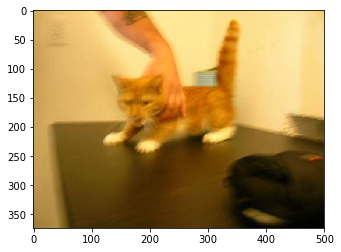

In [13]:
import matplotlib.pyplot as plt
img = plt.imread(f'{PATH}train/cats/cat.0.jpg')
plt.imshow(img);

In [15]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

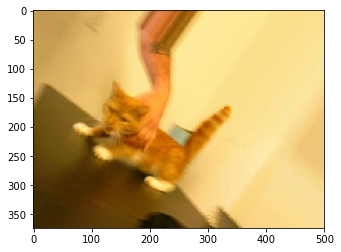

In [17]:
import matplotlib.pyplot as plt
img = plt.imread('preview/cat_0_193.jpeg')
plt.imshow(img);

The code snippet below is our first model, a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers. This is very similar to the architectures that Yann LeCun advocated in the 1990s for image classification (with the exception of ReLU).

In [21]:
from keras import backend as K

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 1000
nb_validation_samples = 400
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

On top of it we stick two fully-connected layers. We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification. To go with it we will also use the binary_crossentropy loss to train our model.

In [22]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Let's prepare our data. We will use .flow_from_directory() to generate batches of image data (and their labels) directly from our jpgs in their respective folders.

In [23]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 1837 images belonging to 2 classes.
Found 913 images belonging to 2 classes.


In [24]:
model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model.save_weights('first_try.h5')  # save your weights after training or during training

Epoch 1/50
125/125 [==============================] - 191s 2s/step - loss: 0.7332 - acc: 0.5442 - val_loss: 0.6609 - val_acc: 0.6575
Epoch 2/50
125/125 [==============================] - 143s 1s/step - loss: 0.6742 - acc: 0.6143 - val_loss: 0.6321 - val_acc: 0.6737
Epoch 3/50
125/125 [==============================] - 141s 1s/step - loss: 0.6460 - acc: 0.6477 - val_loss: 0.5985 - val_acc: 0.7163
Epoch 4/50
125/125 [==============================] - 133s 1s/step - loss: 0.6368 - acc: 0.6827 - val_loss: 0.5853 - val_acc: 0.7075
Epoch 5/50
125/125 [==============================] - 138s 1s/step - loss: 0.6180 - acc: 0.6855 - val_loss: 0.6313 - val_acc: 0.6525
Epoch 6/50
125/125 [==============================] - 136s 1s/step - loss: 0.6097 - acc: 0.6938 - val_loss: 0.6833 - val_acc: 0.6125
Epoch 7/50
125/125 [==============================] - 132s 1s/step - loss: 0.5909 - acc: 0.7117 - val_loss: 0.6082 - val_acc: 0.7137
Epoch 8/50
125/125 [==============================] - 129s 1s/step - 